In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import DateOffset
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, accuracy_score, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit

import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# Create dataframe and features

In [2]:
df = pd.read_csv(
    "../Processed_data/Main_df.csv",
    #index_col=0,           # <— first column becomes the index
    parse_dates=True       # auto–parse that index into datetime
)
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.tail()

,Date,BTC,BTC_Volume,BTC_count,reward,days_since_halving,ETH,ETH_Volume,ETH_count,BCH,...,M2,MSTR,MSTR30,MSTR_Holdings,NVDIA,SP500,day_change,week_change,month_change,6month_change
6309,2025-07-17,119289.842192,7.236384e+10,1.989281e+07,3.125,453.0,3476.784398,4.753285e+10,1.206906e+08,500.064196,...,22020.8,451.339996,9450.0,601550.0,173.000000,6297.359863,0.0,NaN,NaN,NaN
6310,2025-07-18,118003.224496,7.794580e+10,1.989334e+07,3.125,454.0,3549.016245,5.919847e+10,1.207105e+08,514.428382,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,0.0,NaN,NaN,NaN
6311,2025-07-19,117939.978739,4.756456e+10,1.989535e+07,3.125,455.0,3595.273669,2.603172e+10,1.207110e+08,513.423144,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,0.0,NaN,NaN,NaN
6312,2025-07-20,117300.785740,5.751545e+10,1.989606e+07,3.125,456.0,3759.471442,4.460045e+10,1.206943e+08,547.876271,...,22020.8,423.220001,9450.0,601550.0,172.410004,6296.790039,1.0,NaN,NaN,NaN
6313,2025-07-21,117439.535800,6.982009e+10,1.989339e+07,3.125,457.0,3763.371253,4.261147e+10,1.206961e+08,523.554650,...,22020.8,426.279999,15670.0,607770.0,171.380005,6305.600098,NaN,NaN,NaN,NaN


In [3]:
df1=df[["days_since_halving",'Date','BTC','reward']]
df1['log_BTC'] = np.log(df1['BTC'])
df1=df1.dropna()
df1=df1.reset_index()
df1.head()

C:\Users\deepe\AppData\Local\Temp\ipykernel_25344\573367563.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['log_BTC'] = np.log(df1['BTC'])


,index,days_since_halving,Date,BTC,reward,log_BTC
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137


<Axes: title={'center': 'Log of BTC Price Over Time'}>

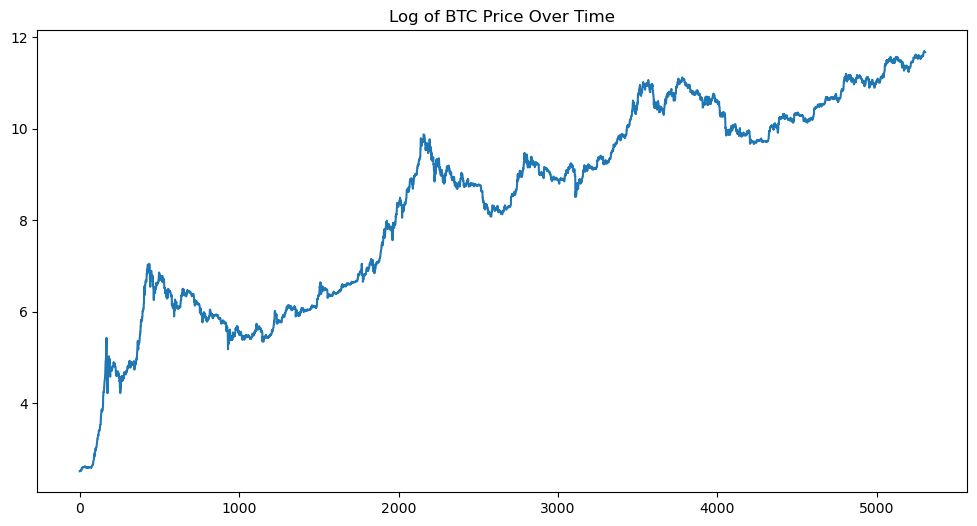

In [4]:
df1['log_BTC'].plot(figsize=(12, 6), title='Log of BTC Price Over Time')

In [5]:
df1["days_total"]=range(len(df1))
df1.head()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851,0
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851,1
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721,2
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721,3
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137,4


In [6]:
df1.describe()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total
count,5304.000000,5304.000000,5304,5304.000000,5304.000000,5304.000000,5304.000000
mean,3661.500000,653.229449,2019-02-25 10:58:38.552036352,19422.217979,13.321903,8.388597,2651.500000
min,1010.000000,0.000000,2012-11-28 00:00:00,12.377134,3.125000,2.515851,0.000000
25%,2335.750000,292.750000,2015-12-24 18:00:00,592.166748,6.250000,6.383788,1325.750000
50%,3661.500000,620.500000,2019-02-07 12:00:00,7679.053719,12.500000,8.946252,2651.500000
75%,4987.250000,1003.250000,2022-04-01 06:00:00,29380.042791,25.000000,10.288071,3977.250000
max,6313.000000,1439.000000,2025-07-21 00:00:00,119849.705720,25.000000,11.693994,5303.000000
std,1531.277245,407.971422,NaN,25965.692310,8.024175,2.217758,1531.277245


In [7]:
df1['day^2']=df1['days_total']**2
df1['day^3']=df1['days_total']**3
df1['day^4']=df1['days_total']**4

df1["Sin1"]= np.sin(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos1"]= np.cos(2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin2"]= np.sin(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos2"]= np.cos(2* 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin3"]= np.sin(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos3"]= np.cos(3 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin4"]= np.sin(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos4"]= np.cos(4 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin5"]= np.sin(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos5"]= np.cos(5 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Sin6"]= np.sin(6 * 2 * np.pi * df1["days_since_halving"] / 1439)
df1["Cos6"]= np.cos(6 * 2 * np.pi * df1["days_since_halving"] / 1439)

df1['SinY1'] = np.sin(2 * np.pi * df1['days_total'] / 365.25)
df1['CosY1'] = np.cos(2 * np.pi * df1['days_total'] / 365.25)
df1['SinY2'] = np.sin(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['CosY2'] = np.cos(2 * 2 * np.pi * df1['days_total'] / 365.25)
df1['SinY3'] = np.sin(3 * 2 * np.pi * df1['days_total'] / 365.25) 
df1['CosY3'] = np.cos(3 * 2 * np.pi * df1['days_total'] / 365.25)

df1.head()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total,day^2,day^3,day^4,...,Sin5,Cos5,Sin6,Cos6,SinY1,CosY1,SinY2,CosY2,SinY3,CosY3
0,1010,0.0,2012-11-28,12.377134,25.0,2.515851,0,0,0,0,...,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,1011,0.0,2012-11-28,12.377134,25.0,2.515851,1,1,1,1,...,0.00000,1.000000,0.000000,1.000000,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669
2,1012,1.0,2012-11-29,12.450000,25.0,2.521721,2,4,8,16,...,0.02183,0.999762,0.026195,0.999657,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678
3,1013,1.0,2012-11-29,12.450000,25.0,2.521721,3,9,27,81,...,0.02183,0.999762,0.026195,0.999657,0.051584,0.998669,0.103031,0.994678,0.154204,0.988039
4,1014,2.0,2012-11-30,12.605554,25.0,2.534137,4,16,64,256,...,0.04365,0.999047,0.052372,0.998628,0.068755,0.997634,0.137185,0.990545,0.204966,0.978769


In [8]:
df1['day reward'] = df1['days_total'] * df1['reward']
df1['day^2 reward']= df1['day^2'] * df1['reward']

df1['Sin1 reward'] = df1['Sin1'] * df1['reward']
df1['Cos1 reward'] = df1['Cos1'] * df1['reward']
df1['Sin2 reward'] = df1['Sin2'] * df1['reward']
df1['Cos2 reward'] = df1['Cos2'] * df1['reward']
df1['Sin3 reward'] = df1['Sin3'] * df1['reward']
df1['Cos3 reward'] = df1['Cos3'] * df1['reward']
df1['Sin4 reward'] = df1['Sin4'] * df1['reward']
df1['Cos4 reward'] = df1['Cos4'] * df1['reward']

df1.tail()

,index,days_since_halving,Date,BTC,reward,log_BTC,days_total,day^2,day^3,day^4,...,day reward,day^2 reward,Sin1 reward,Cos1 reward,Sin2 reward,Cos2 reward,Sin3 reward,Cos3 reward,Sin4 reward,Cos4 reward
5299,6309,453.0,2025-07-17,119289.842192,3.125,11.689311,5299,28079401,148792745899,788452760518801,...,16559.375,8.774813e+07,2.869525,-1.237517,-2.272696,-2.144873,-1.069525,2.936280,3.119772,-0.180694
5300,6310,454.0,2025-07-18,118003.224496,3.125,11.678467,5300,28090000,148877000000,789048100000000,...,16562.500,8.778125e+07,2.864095,-1.250035,-2.291339,-2.124944,-1.030972,2.950038,3.116140,-0.235151
5301,6311,455.0,2025-07-19,117939.978739,3.125,11.677931,5301,28100601,148961285901,789643776561201,...,16565.625,8.781438e+07,2.858609,-1.262528,-2.309808,-2.104854,-0.992242,2.963289,3.111558,-0.289537
5302,6312,456.0,2025-07-20,117300.785740,3.125,11.672497,5302,28111204,149045603608,790239790329616,...,16568.750,8.784751e+07,2.853069,-1.274998,-2.328101,-2.084603,-0.953342,2.976032,3.106027,-0.343835
5303,6313,457.0,2025-07-21,117439.535800,3.125,11.673679,5303,28121809,149129953127,790836141432481,...,16571.875,8.788065e+07,2.847475,-1.287443,-2.346216,-2.064193,-0.914278,2.988264,3.099548,-0.398028


# Different models for trend and seasonality

## Model 0 with trend alone

time alone

In [18]:
X = df1[["days_total"]]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.8306, test RMSE: 0.6636
2749 365
Fold 4 → train RMSE: 0.8003, test RMSE: 0.4717
3114 365
Fold 5 → train RMSE: 0.7648, test RMSE: 0.5366
3479 365
Fold 6 → train RMSE: 0.7390, test RMSE: 0.4800
3844 365
Fold 7 → train RMSE: 0.7146, test RMSE: 0.9571
4209 365
Fold 8 → train RMSE: 0.7267, test RMSE: 1.4036
4574 365
Fold 9 → train RMSE: 0.7740, test RMSE: 0.8281
4939 365
Fold 10 → train RMSE: 0.7699, test RMSE: 0.5461
Average Train RMSE: 0.7649866264682491
Average Test RMSE: 0.7358370614841593


time and time^2

In [19]:
X = df1[["days_total",'day^2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.8068, test RMSE: 1.2925
2749 365
Fold 4 → train RMSE: 0.8003, test RMSE: 0.5032
3114 365
Fold 5 → train RMSE: 0.7616, test RMSE: 0.3915
3479 365
Fold 6 → train RMSE: 0.7295, test RMSE: 0.8027
3844 365
Fold 7 → train RMSE: 0.7142, test RMSE: 0.8932
4209 365
Fold 8 → train RMSE: 0.7112, test RMSE: 0.9838
4574 365
Fold 9 → train RMSE: 0.7099, test RMSE: 0.2498
4939 365
Fold 10 → train RMSE: 0.6864, test RMSE: 0.4688
Average Train RMSE: 0.7400000860507778
Average Test RMSE: 0.698187948739065


## Model 1: Trend and seasonality from halving cycle

In [20]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.4789, test RMSE: 0.2470
2749 365
Fold 4 → train RMSE: 0.4547, test RMSE: 1.0117
3114 365
Fold 5 → train RMSE: 0.4727, test RMSE: 0.8145
3479 365
Fold 6 → train RMSE: 0.4736, test RMSE: 0.6225
3844 365
Fold 7 → train RMSE: 0.4699, test RMSE: 0.9240
4209 365
Fold 8 → train RMSE: 0.4780, test RMSE: 0.3816
4574 365
Fold 9 → train RMSE: 0.4699, test RMSE: 0.5799
4939 365
Fold 10 → train RMSE: 0.4653, test RMSE: 0.3951
Average Train RMSE: 0.4703769078200387
Average Test RMSE: 0.6220377984480545


Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3700, test RMSE: 0.5065


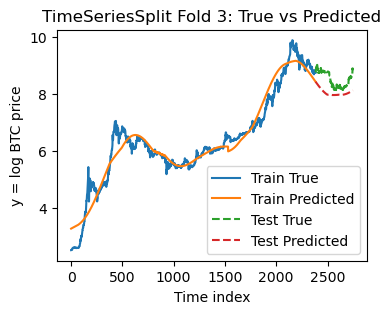

2749 365
Fold 4 → train RMSE: 0.3617, test RMSE: 0.3361


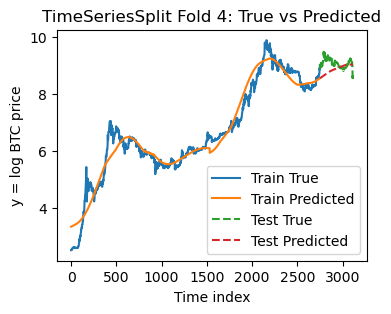

3114 365
Fold 5 → train RMSE: 0.3535, test RMSE: 0.3305


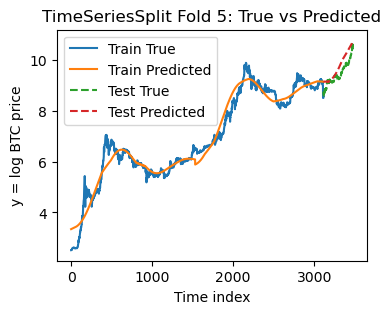

3479 365
Fold 6 → train RMSE: 0.3419, test RMSE: 1.1484


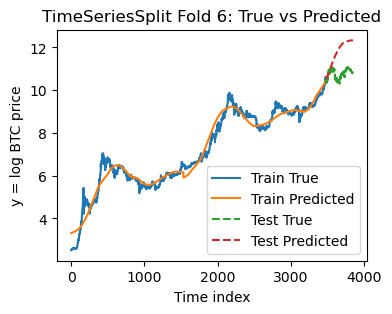

3844 365
Fold 7 → train RMSE: 0.3910, test RMSE: 0.6125


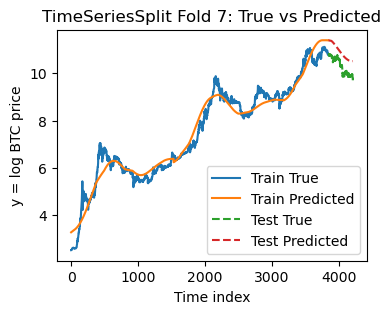

4209 365
Fold 8 → train RMSE: 0.3892, test RMSE: 0.2331


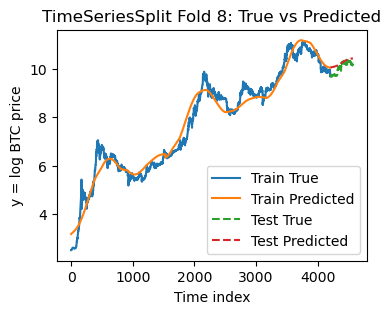

4574 365
Fold 9 → train RMSE: 0.3767, test RMSE: 0.6001


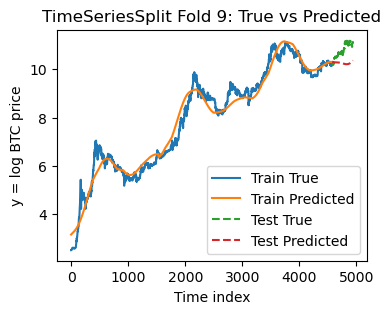

4939 365
Fold 10 → train RMSE: 0.3810, test RMSE: 0.4884


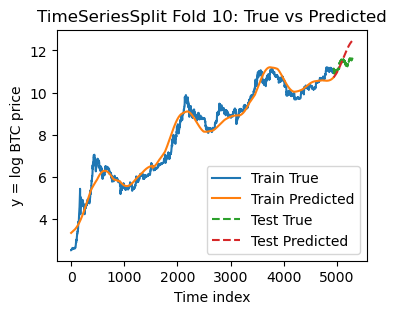

Average Train RMSE: 0.37062012569605285
Average Test RMSE: 0.5319513710906038


In [21]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

In [23]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2', 'Sin3', 'Cos3']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3660, test RMSE: 0.6036
2749 365
Fold 4 → train RMSE: 0.3605, test RMSE: 0.2941
3114 365
Fold 5 → train RMSE: 0.3488, test RMSE: 0.4033
3479 365
Fold 6 → train RMSE: 0.3401, test RMSE: 1.1405
3844 365
Fold 7 → train RMSE: 0.3858, test RMSE: 0.6702
4209 365
Fold 8 → train RMSE: 0.3868, test RMSE: 0.2196
4574 365
Fold 9 → train RMSE: 0.3739, test RMSE: 0.6514
4939 365
Fold 10 → train RMSE: 0.3806, test RMSE: 0.4933
Average Train RMSE: 0.36780411626698833
Average Test RMSE: 0.559494838385469


In [25]:
X = df1[["days_total", 'Sin1', 'Cos1', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3708, test RMSE: 0.3988
2749 365
Fold 4 → train RMSE: 0.3633, test RMSE: 0.4252
3114 365
Fold 5 → train RMSE: 0.3602, test RMSE: 0.1677
3479 365
Fold 6 → train RMSE: 0.3445, test RMSE: 1.0026
3844 365
Fold 7 → train RMSE: 0.4053, test RMSE: 0.9965
4209 365
Fold 8 → train RMSE: 0.4465, test RMSE: 0.9851
4574 365
Fold 9 → train RMSE: 0.4799, test RMSE: 0.4307
4939 365
Fold 10 → train RMSE: 0.4721, test RMSE: 1.1995
Average Train RMSE: 0.40531909044077985
Average Test RMSE: 0.7007569017891815


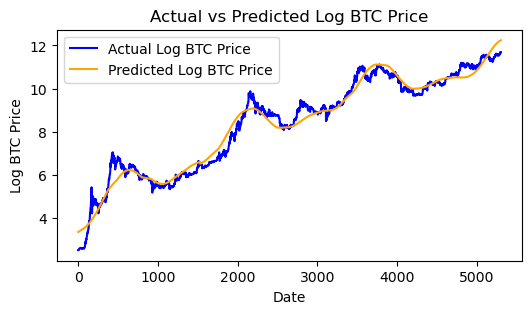

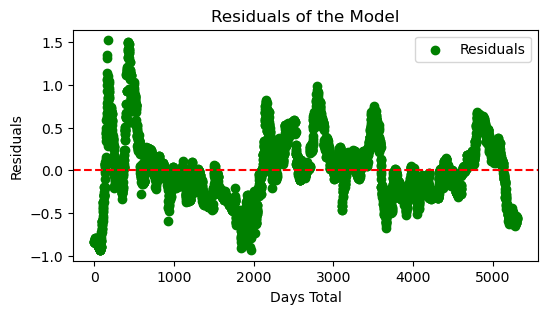

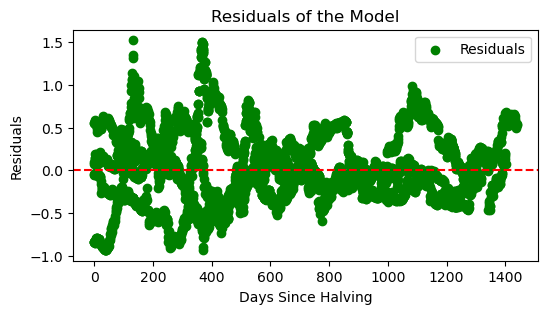

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_BTC   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 2.864e+04
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:41:19   Log-Likelihood:                -2441.8
No. Observations:                5304   AIC:                             4898.
Df Residuals:                    5297   BIC:                             4944.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.8223      0.017    231.652      0.000       3.790       3.855
days_total     0.0023   1.44e-05    161.999      0.000       0.002       0.002
day^2      -1.778e-07   2.64e-09    -67.296      0.000   -1.83e-07   -1.73e-07
Sin1           0.6025      0.008     79.662      0.000       0.588       0.617
Cos1          -0.3503      0.008    -44.533      0.000      -0.366      -0.335
Sin2          -0.3217      0.007    -43.591      0.000      -0.336      -0.307
Cos2          -0.1142      0.008    -14.936      0.000      -0.129      -0.099
==============================================================================
Omnibus:                      202.045   Durbin-Watson:                   0.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              246.220
Skew:                           0.433   Prob(JB):                     3.42e-54
Kurtosis:                       3.604   Cond. No.                     3.98e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.98e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2']]
y= df1["log_BTC"]
X= sm.add_constant(X)  # Adding a constant term for the intercept

model0=sm.OLS(y, X).fit()
y_pred = model0.predict(X)

plt.figure(figsize=(6, 3))
plt.plot(df1['days_total'], y, label='Actual Log BTC Price', color='blue')
plt.plot(df1['days_total'], y_pred, label='Predicted Log BTC Price', color='orange')
plt.title('Actual vs Predicted Log BTC Price')
plt.xlabel('Date')
plt.ylabel('Log BTC Price')
plt.legend()
plt.show()

residues = y - y_pred
plt.figure(figsize=(6, 3))
plt.scatter(df1['days_total'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Total')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(df1['days_since_halving'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Since Halving')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()


model0.summary()

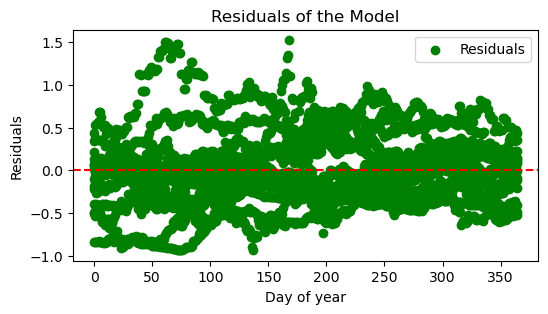

In [27]:
X['Day_of_Year']=X['days_total'] % 365
plt.figure(figsize=(6, 3))
plt.scatter(X['Day_of_Year'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Day of year')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

C:\Users\deepe\AppData\Local\Temp\ipykernel_26500\2341584452.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


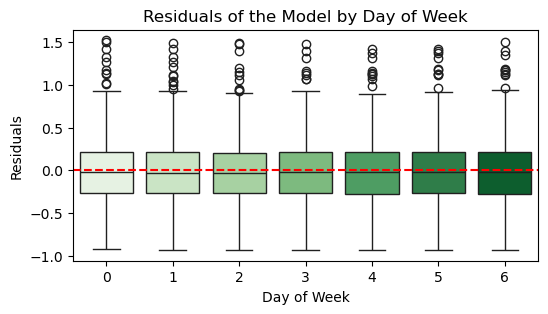

In [30]:
X['Day_of_Week']=X['days_total'] % 7
plt.figure(figsize=(6, 3))
sns.boxplot(
    x=X['Day_of_Week'],
    y=residues,
    palette="Greens"     # optional: pick a color palette
)
plt.title('Residuals of the Model by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.show()

## Model 2: Trend, Seasonality from halving cycle and yearly seasonality

In [31]:
X = df1[["days_total",'day^2', 'Sin1', 'Cos1', 'Sin2', 'Cos2', 'SinY1', 'CosY1']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    #plt.figure(figsize=(4, 3))
    # training: solid lines
    #plt.plot(train_idx, y_train,      label="Train True")
    #plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    #plt.plot(test_idx, y_test,        '--', label="Test True")
    #plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    #plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    #plt.xlabel("Time index")
    #plt.ylabel("y = log BTC price")
    #plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3649, test RMSE: 0.5449
2749 365
Fold 4 → train RMSE: 0.3578, test RMSE: 0.3160
3114 365
Fold 5 → train RMSE: 0.3476, test RMSE: 0.3260
3479 365
Fold 6 → train RMSE: 0.3361, test RMSE: 1.1364
3844 365
Fold 7 → train RMSE: 0.3817, test RMSE: 0.6374
4209 365
Fold 8 → train RMSE: 0.3829, test RMSE: 0.2812
4574 365
Fold 9 → train RMSE: 0.3728, test RMSE: 0.6080
4939 365
Fold 10 → train RMSE: 0.3786, test RMSE: 0.4842
Average Train RMSE: 0.36531529270401664
Average Test RMSE: 0.5417574997299401


## Model 3: Adjust based on reduced reward

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3516, test RMSE: 0.8103


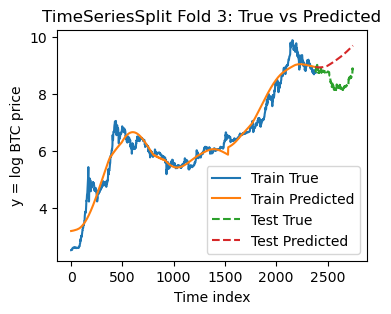

2749 365
Fold 4 → train RMSE: 0.3654, test RMSE: 0.3209


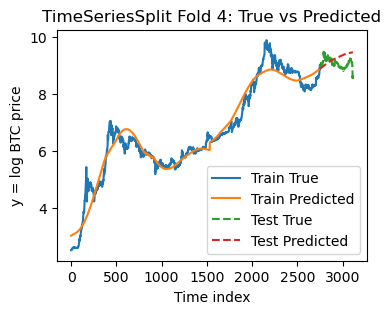

3114 365
Fold 5 → train RMSE: 0.3558, test RMSE: 0.4686


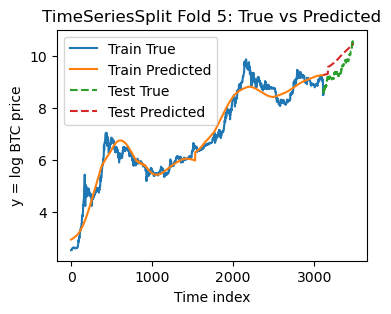

3479 365
Fold 6 → train RMSE: 0.3524, test RMSE: 0.2987


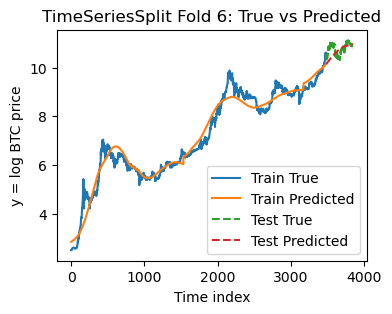

3844 365
Fold 7 → train RMSE: 0.3470, test RMSE: 0.7922


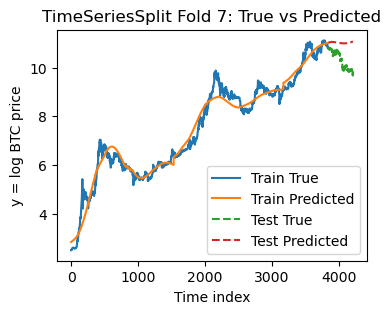

4209 365
Fold 8 → train RMSE: 0.3680, test RMSE: 0.6738


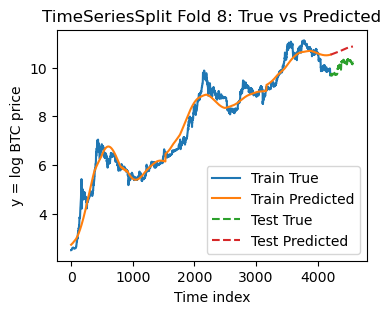

4574 365
Fold 9 → train RMSE: 0.3768, test RMSE: 0.3630


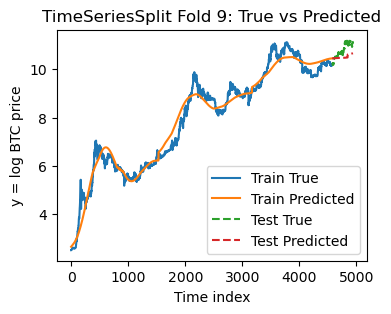

4939 365
Fold 10 → train RMSE: 0.3718, test RMSE: 0.3276


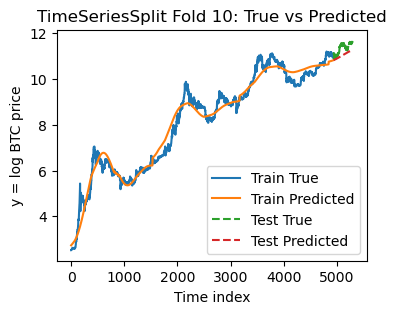

Average Train RMSE: 0.3610949656558287
Average Test RMSE: 0.5068994372744993


In [32]:
X = df1[["days_total",'day^2', 'Sin1 reward', 'Cos1 reward', 'Sin2 reward', 'Cos2 reward']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3511, test RMSE: 0.4278


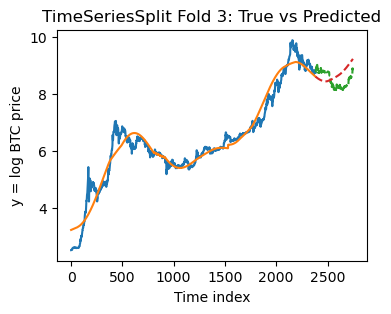

2749 365
Fold 4 → train RMSE: 0.3516, test RMSE: 0.5360


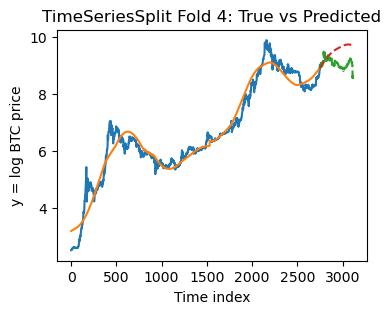

3114 365
Fold 5 → train RMSE: 0.3517, test RMSE: 0.2163


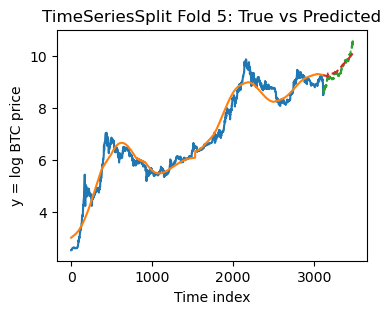

3479 365
Fold 6 → train RMSE: 0.3389, test RMSE: 0.4102


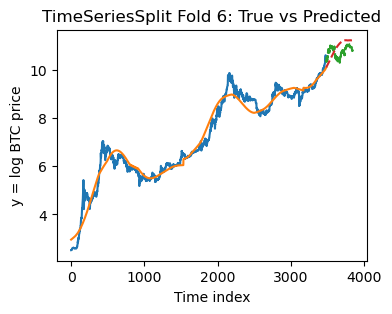

3844 365
Fold 7 → train RMSE: 0.3419, test RMSE: 0.4846


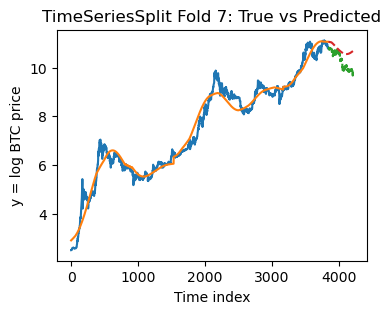

4209 365
Fold 8 → train RMSE: 0.3410, test RMSE: 0.7605


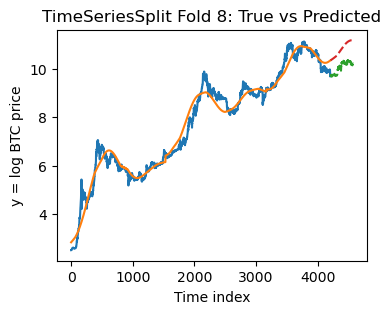

4574 365
Fold 9 → train RMSE: 0.3549, test RMSE: 0.5015


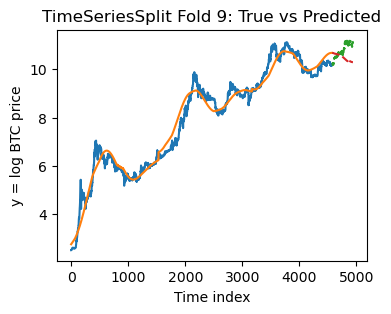

4939 365
Fold 10 → train RMSE: 0.3617, test RMSE: 0.4688


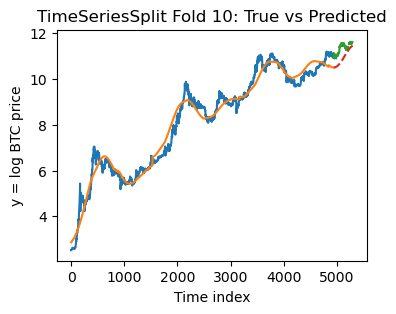

Average Train RMSE: 0.34908407133901553
Average Test RMSE: 0.4757168034747728


In [33]:
X = df1[["days_total",'day^2','Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

# Final model for Trend and Seasonality

Fold 1 skipped: not enough training data.
Fold 2 skipped: not enough training data.
2384 365
Fold 3 → train RMSE: 0.3511, test RMSE: 0.4278


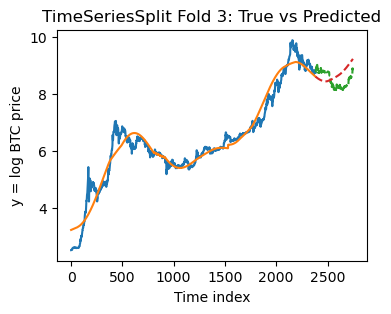

2749 365
Fold 4 → train RMSE: 0.3516, test RMSE: 0.5360


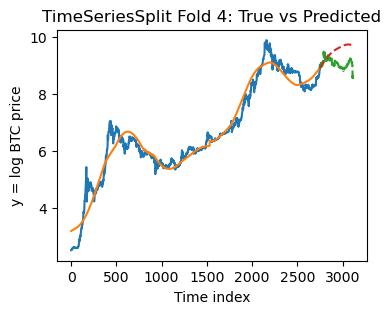

3114 365
Fold 5 → train RMSE: 0.3517, test RMSE: 0.2163


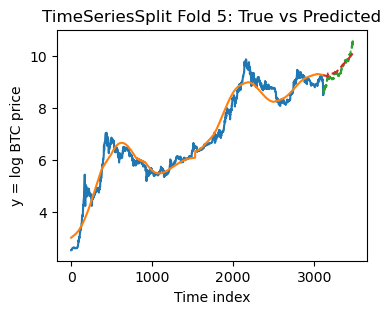

3479 365
Fold 6 → train RMSE: 0.3389, test RMSE: 0.4102


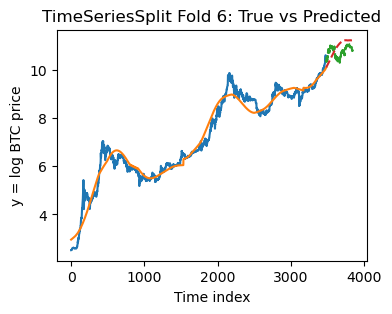

3844 365
Fold 7 → train RMSE: 0.3419, test RMSE: 0.4846


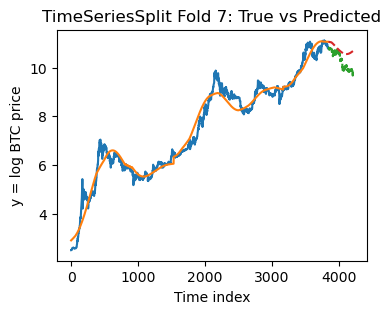

4209 365
Fold 8 → train RMSE: 0.3410, test RMSE: 0.7605


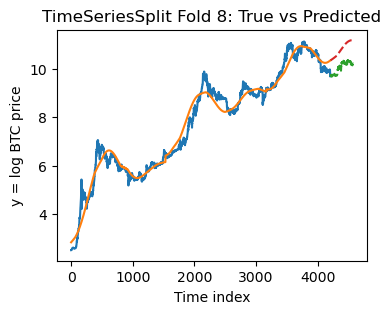

4574 365
Fold 9 → train RMSE: 0.3549, test RMSE: 0.5015


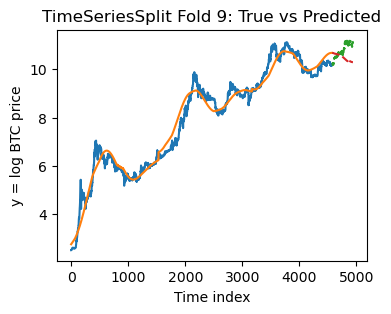

4939 365
Fold 10 → train RMSE: 0.3617, test RMSE: 0.4688


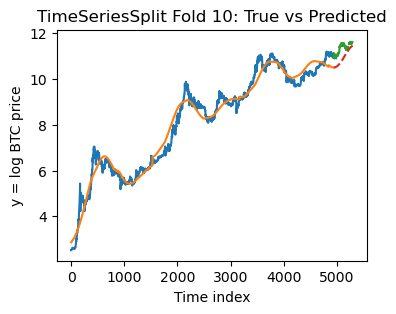

Average Train RMSE: 0.34908407133901553
Average Test RMSE: 0.4757168034747728


In [34]:
X = df1[["days_total",'day^2','Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]

X= sm.add_constant(X)  # Adding a constant term for the intercept
train_rmse_list=[]
test_rmse_list=[]

tscv = TimeSeriesSplit(
    n_splits=10,
    test_size=365,     # hold out one-year blocks
    gap=0               # no gap between train/test
)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    if len(train_idx) < 6*365:   # ensure at least 6 years of training data
        print(f"Fold {fold} skipped: not enough training data.")
        continue
    # split
    print(len(train_idx), len(test_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # fit
    model = sm.OLS(y_train, X_train).fit()
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    # optional: track MSE
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse  = root_mean_squared_error(y_test,  y_test_pred)
    print(f"Fold {fold} → train RMSE: {train_rmse:.4f}, test RMSE: {test_rmse:.4f}")

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

    # plot
    plt.figure(figsize=(4, 3))
    # training: solid lines
    plt.plot(train_idx, y_train,      label="Train True")
    plt.plot(train_idx, y_train_pred, label="Train Predicted")
    # test: dashed lines
    plt.plot(test_idx, y_test,        '--', label="Test True")
    plt.plot(test_idx, y_test_pred,   '--', label="Test Predicted")

    #plt.legend()
    plt.title(f"TimeSeriesSplit Fold {fold}: True vs Predicted")
    plt.xlabel("Time index")
    plt.ylabel("y = log BTC price")
    plt.show()

print("Average Train RMSE:", np.mean(train_rmse_list))
print("Average Test RMSE:", np.mean(test_rmse_list))

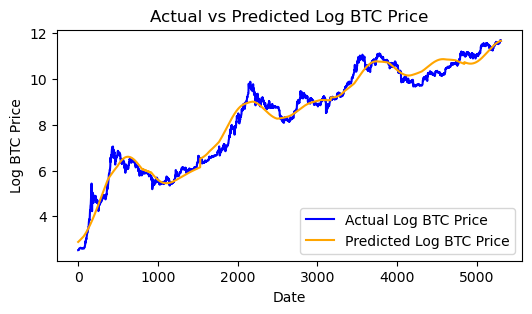

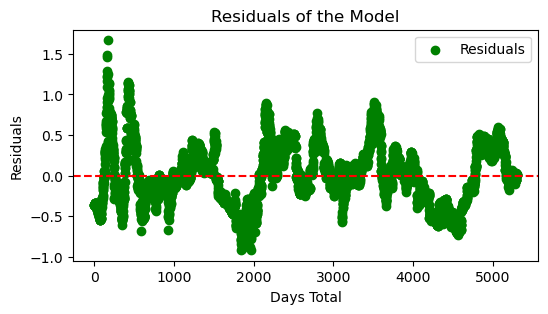

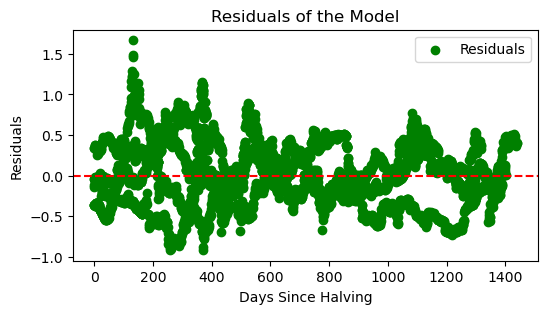

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                log_BTC   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 3.230e+04
Date:                Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                        15:48:13   Log-Likelihood:                -2132.6
No. Observations:                5304   AIC:                             4279.
Df Residuals:                    5297   BIC:                             4325.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           3.6606      0.016    228.346      0.000       3.629       3.692
days_total      0.0025    1.4e-05    177.776      0.000       0.002       0.003
day^2       -2.017e-07   2.53e-09    -79.777      0.000   -2.07e-07   -1.97e-07
Sin1 reward     0.0399      0.000     85.100      0.000       0.039       0.041
Cos1 reward    -0.0246      0.000    -51.588      0.000      -0.026      -0.024
Sin2           -0.3022      0.007    -43.443      0.000      -0.316      -0.289
Cos2           -0.1693      0.007    -23.424      0.000      -0.183      -0.155
==============================================================================
Omnibus:                       64.773   Durbin-Watson:                   0.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.971
Skew:                           0.274   Prob(JB):                     2.87e-15
Kurtosis:                       2.945   Cond. No.                     4.06e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
X = df1[["days_total",'day^2', 'Sin1 reward', 'Cos1 reward', 'Sin2', 'Cos2']]
y= df1["log_BTC"]
X= sm.add_constant(X)  # Adding a constant term for the intercept

model0=sm.OLS(y, X).fit()
y_pred = model0.predict(X)

plt.figure(figsize=(6, 3))
plt.plot(df1['days_total'], y, label='Actual Log BTC Price', color='blue')
plt.plot(df1['days_total'], y_pred, label='Predicted Log BTC Price', color='orange')
plt.title('Actual vs Predicted Log BTC Price')
plt.xlabel('Date')
plt.ylabel('Log BTC Price')
plt.legend()
plt.show()

residues = y - y_pred
plt.figure(figsize=(6, 3))
plt.scatter(df1['days_total'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Total')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(6, 3))
plt.scatter(df1['days_since_halving'], residues, label='Residuals', color='green')
plt.title('Residuals of the Model')
plt.xlabel('Days Since Halving')
plt.ylabel('Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.show()


model0.summary()

# Evaluation for directional predictions

## Evaluation for 1 day in future

In [ ]:
Days=1
print(f"Predicting directional change {Days}-days in the future")

data= df1.copy()

data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"],
    1, 0
)



# drop the very last row since Delta_true is NaN there
#data = data.dropna(subset=["Delta_true"]).copy()

# 2. Prepare containers for predictions
y_true = []
y_pred = []

# 3. Rolling loop: for each t from some min_train to len(df)-2
min_train = 365*6  # e.g. start after 1 year of data
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-1}",end="\r", flush=True)
    # a) train on rows [0…t]
    train = data.iloc[:t+1]
    X_train = train[["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    y_train = train["log_BTC"]
    
    model = LinearRegression().fit(X_train, y_train)
    
    # b) predict log-price at t and at t+1
    X_t   = data.iloc[[t]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    X_t1  = data.iloc[[t+Days]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    
    y_hat_t  = model.predict(X_t)[0]
    y_hat_t1 = model.predict(X_t1)[0]
    
    # c) record true and predicted direction at time t
    y_true.append(int(data.iloc[t]["Delta_true"]))
    delta_pred = 1 if (y_hat_t1 > y_hat_t) else 0
    y_pred.append(delta_pred)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")




# 4. Compute accuracy and confusion matrix
acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print(f"Directional Accuracy: {acc:.3%}")
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)


Predicting directional change 1-days in the future
Baselines: time index 5300 / 5303
  Always predict UP (1):        45.519%
  Always predict DOWN (0):      54.481%
  Predict same as past:    47.558%
  Predict opposite of past:52.442%
Directional Accuracy: 44.555%
Confusion Matrix (rows=true, cols=pred):
[[ 523 1173]
 [ 553  864]]


## Evaluate 7 days from now

In [11]:
Days=7
print(f"Predicting directional change {Days}-days in the future")

data= df1.copy()

data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"],
    1, 0
)



# drop the very last row since Delta_true is NaN there
#data = data.dropna(subset=["Delta_true"]).copy()

# 2. Prepare containers for predictions
y_true = []
y_pred = []

# 3. Rolling loop: for each t from some min_train to len(df)-2
min_train = 365*6  # e.g. start after 1 year of data
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-Days}",end="\r", flush=True)
    # a) train on rows [0…t]
    train = data.iloc[:t+1]
    X_train = train[["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    y_train = train["log_BTC"]
    
    model = LinearRegression().fit(X_train, y_train)
    
    # b) predict log-price at t and at t+1
    X_t   = data.iloc[[t]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    X_t1  = data.iloc[[t+Days]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    
    y_hat_t  = model.predict(X_t)[0]
    y_hat_t1 = model.predict(X_t1)[0]
    
    # c) record true and predicted direction at time t
    y_true.append(int(data.iloc[t]["Delta_true"]))
    delta_pred = 1 if (y_hat_t1 > y_hat_t) else 0
    y_pred.append(delta_pred)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")




# 4. Compute accuracy and confusion matrix
acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print(f"Directional Accuracy: {acc:.3%}")
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)


Predicting directional change 7-days in the future
Processing time index 5200 / 5303
Baselines:
  Always predict UP (1):        52.333%
  Always predict DOWN (0):      47.667%
  Predict same as past:    48.903%
  Predict opposite of past:51.097%
Directional Accuracy: 51.143%
Confusion Matrix (rows=true, cols=pred):
[[ 553  928]
 [ 590 1036]]


## Evaluating 30 days from now

In [13]:
Days=30
print(f"Predicting directional change {Days}-days in the future")

data= df1.copy()

data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"],
    1, 0
)



# drop the very last row since Delta_true is NaN there
#data = data.dropna(subset=["Delta_true"]).copy()

# 2. Prepare containers for predictions
y_true = []
y_pred = []

# 3. Rolling loop: for each t from some min_train to len(df)-2
min_train = 365*6  # e.g. start after 1 year of data
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-Days}",end="\r", flush=True)
    # a) train on rows [0…t]
    train = data.iloc[:t+1]
    X_train = train[["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    y_train = train["log_BTC"]
    
    model = LinearRegression().fit(X_train, y_train)
    
    # b) predict log-price at t and at t+1
    X_t   = data.iloc[[t]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    X_t1  = data.iloc[[t+Days]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    
    y_hat_t  = model.predict(X_t)[0]
    y_hat_t1 = model.predict(X_t1)[0]
    
    # c) record true and predicted direction at time t
    y_true.append(int(data.iloc[t]["Delta_true"]))
    delta_pred = 1 if (y_hat_t1 > y_hat_t) else 0
    y_pred.append(delta_pred)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")




# 4. Compute accuracy and confusion matrix
acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print(f"Directional Accuracy: {acc:.3%}")
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)


Predicting directional change 30-days in the future
Processing time index 5200 / 5274
Baselines:
  Always predict UP (1):        53.956%
  Always predict DOWN (0):      46.044%
  Predict same as past:    50.589%
  Predict opposite of past:49.411%
Directional Accuracy: 53.470%
Confusion Matrix (rows=true, cols=pred):
[[ 539  881]
 [ 554 1110]]


## Evaluate 180 days from now

In [14]:
Days=180
print(f"Predicting directional change {Days}-days in the future")

data= df1.copy()

data["Delta_true"] = np.where(
    data["log_BTC"].shift(-Days) > data["log_BTC"],
    1, 0
)



# drop the very last row since Delta_true is NaN there
#data = data.dropna(subset=["Delta_true"]).copy()

# 2. Prepare containers for predictions
y_true = []
y_pred = []

# 3. Rolling loop: for each t from some min_train to len(df)-2
min_train = 365*6  # e.g. start after 1 year of data
n = len(data)

for t in range(min_train, n - Days):
    if t % 100 == 0:
        print(f"Processing time index {t} / {n-Days}",end="\r", flush=True)
    # a) train on rows [0…t]
    train = data.iloc[:t+1]
    X_train = train[["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    y_train = train["log_BTC"]
    
    model = LinearRegression().fit(X_train, y_train)
    
    # b) predict log-price at t and at t+1
    X_t   = data.iloc[[t]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    X_t1  = data.iloc[[t+Days]][["days_total", "day^2", "Sin1 reward", "Cos1 reward", "Sin2", "Cos2"]]
    
    y_hat_t  = model.predict(X_t)[0]
    y_hat_t1 = model.predict(X_t1)[0]
    
    # c) record true and predicted direction at time t
    y_true.append(int(data.iloc[t]["Delta_true"]))
    delta_pred = 1 if (y_hat_t1 > y_hat_t) else 0
    y_pred.append(delta_pred)

always1_acc = np.mean(y_true)

# 2) Always predict “0” (price goes down or stays)
always0_acc = 1 - always1_acc

# 3) Yesterday’s sign predictor:
#    predict Δ̂_t = Δ_true_{t-1}
yt = np.array(y_true)
#    we can only predict from the second point onward
lag_preds = yt[:-Days]
lag_trues = yt[Days:]
lag_acc   = accuracy_score(lag_trues, lag_preds)

# 4) Opposite‐of‐yesterday predictor:
opp_lag_acc = 1 - lag_acc

# --- print everything --- #
print()
print("Baselines:")
print(f"  Always predict UP (1):        {always1_acc:.3%}")
print(f"  Always predict DOWN (0):      {always0_acc:.3%}")
print(f"  Predict same as past:    {lag_acc:.3%}")
print(f"  Predict opposite of past:{opp_lag_acc:.3%}")




# 4. Compute accuracy and confusion matrix
acc = accuracy_score(y_true, y_pred)
cm  = confusion_matrix(y_true, y_pred)

print(f"Directional Accuracy: {acc:.3%}")
print("Confusion Matrix (rows=true, cols=pred):")
print(cm)


Predicting directional change 180-days in the future
Processing time index 5100 / 5124
Baselines:
  Always predict UP (1):        62.100%
  Always predict DOWN (0):      37.900%
  Predict same as past:    61.365%
  Predict opposite of past:38.635%
Directional Accuracy: 70.450%
Confusion Matrix (rows=true, cols=pred):
[[ 554  558]
 [ 309 1513]]
